# Exploring analytic solutions of double delta function potential 

In quantum mechanics the delta potential is a potential well mathematically described by the Dirac delta function that is a generalized function. Qualitatively, it corresponds to a potential which is zero everywhere except at a single point where it takes an infinite value. This can be used to simulate situations where a particle is free to move in two regions of space with a barrier between the two regions. For example an electron can move almost freely in a conducting material but if two conducting surfaces are put close together the interface between them acts as a barrier for the electron that can be approximated by a delta potential.

A pair of attractive Dirac delta-wells separated by a distance $R$ is the one-dimensional analogue of the $\mathrm{H}_2^{+}$ molecular ion. This is the double delta function potential in action where two protons create the double potential for the single electron. In atomic units $(\hbar = m = 1)$ the time-independent Schrödinger equation reads

$$
-\frac{1}{2}\,\psi''(x)\;-\;
\lambda\!\left[
\delta\!\Bigl(x-\tfrac{R}{2}\Bigr) \;+\;
\delta\!\Bigl(x+\tfrac{R}{2}\Bigr)
\right]
\psi(x)
\;=\;
E\,\psi(x),
$$

where  

* **$\lambda>0$** acts like the “nuclear charge” (depth/strength of each delta-well),  
* **$R$** is the internuclear separation.

Because the potential is zero everywhere except at $x=\pm R/2$, the bound-state wave-functions away from those points are simple decaying exponentials, their decay constant is fixed by matching the $\delta$-function discontinuities of $\psi'(x)$.


What the studies in this notebook are:
1. Plotting the analytic wavefunctions and energies
2. Comparing analytic and numeric solutions to verify validity
3. Check variation in energy splitting dependent on $\lambda$ and $R$
4. Normalisation error and computational effeciency

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw #The lambert W function
import numpy.linalg as npeg
import time
zerref = 1e-12 #zero reference

Defining a class that contains the parameters that some quantities depend on

In [2]:
class PhysicalParameters: 
    def __init__(self,lambdda,R,x_min=-4.0,x_max=4.0,nx=2001):
        self.lambdda=lambdda # the nuclear charge
        self.R=R #distance/separation
        self.x_min=x_min 
        self.x_max=x_max # just our box length,with nx being grid points
        self.nx=nx
   
    def grid(self):
        return np.linspace(self.x_min,self.x_max,self.nx,dtype=float) #grid
    
p=PhysicalParameters(lambdda=1.0,R=2.0) 
#Default object for some initial testing with parameter values that are consider standard and easier to refer

The double-delta potential supports two bound states distinguished by their spatial parity:

| state | wave-function symmetry | decay constant | energy |
|-------|-----------------------|----------------|---------|
| even  | bonding (no node)     | $\alpha_{+}$   | $E_{+}$ |
| odd   | anti-bonding (one node)| $\alpha_{-}$  | $E_{-}$ |

Matching the derivative jump at each Dirac δ-well leads to
$$
\alpha_{\pm}= \lambda\!\left(1 \pm e^{-\alpha_{\pm}R}\right)
\tag{1}
$$
where $\lambda$ is the well strength and $R$ the separation. In alpha_main the argument sign = ±1 chooses the upper (even) or lower (odd) sign in eqn(1) which now can be solved by inverting with the Lambert $W$ (product-log) function, defined by $W(z),e^{W(z)}=z$:
$$
\alpha_{\pm}= \lambda \;+\; \frac{1}{R}\, W\!\bigl(\,\pm\,\lambda R e^{-\lambda R}\bigr)
\tag{2}
$$
alpha_main evaluates eqn(2). With $\alpha_{\pm}$ in hand the Schrödinger equation gives (which will be verified later)
$$
E_{\pm}= -\frac{\alpha_{\pm}^{2}}{2}
\tag{3}
$$

In [3]:
def alpha_main(lambdda,R,sign): #Used to build both alphas depending on sign + or -
    arg = sign*lambdda*R*np.exp(-lambdda*R)
    return (lambdda+ lambertw(arg).real / (R+zerref))

def alpha_even(physpar): 
    return alpha_main(physpar.lambdda,physpar.R,1)

def alpha_odd(physpar):
    return alpha_main(physpar.lambdda,physpar.R,-1)

def energy_even(physpar):
    a=alpha_even(physpar)
    return -0.5*a*a

def energy_odd(physpar):
    a=alpha_odd(physpar)
    return -0.5*a*a

For a decay constant $\alpha$ the two parity states are
$$
\psi^{+}_{\text{raw}}(x)
   \;=\;
   e^{-\alpha\,\bigl|x-\tfrac{R}{2}\bigr|}
   \;+\;
   e^{-\alpha\,\bigl|x+\tfrac{R}{2}\bigr|},
\qquad
\psi^{-}_{\text{raw}}(x)
   \;=\;
   e^{-\alpha\,\bigl|x-\tfrac{R}{2}\bigr|}
   \;-\;
   e^{-\alpha\,\bigl|x+\tfrac{R}{2}\bigr|}
\tag{4}
$$
For normalisation, the square integral of either ansatz is
$$
N_{\pm}^{-2}
   = 2\,\alpha^{-1}
     \;\pm\;2\,R\,e^{-\alpha R}
     + 2\,\alpha^{-1}\,e^{-\alpha R}
\tag{5}
$$
but instead of inserting eqn(5) the code applies a numerical trapezoid which is both concise and automatically adapts to any grid spacing $\Delta x$ we select

In [4]:
def psi_raw(x,alpha,R,parity): # Unnormalised Wave function
    if parity== "even":
        return np.exp(-alpha*np.abs(x-R/2)) + np.exp(-alpha*np.abs(x+R/2))
    elif parity== "odd":
        return np.exp(-alpha*np.abs(x-R/2)) - np.exp(-alpha*np.abs(x+R/2))
    else:
        raise ValueError("parity must be even or odd")

def normalise(psi,x): # Normalised Wave function
    norm=np.trapz(psi**2,x)
    return psi/np.sqrt(norm)

def psi_even(x,physpar): #Even wave function
    alpha=alpha_even(physpar)
    return normalise(psi_raw(x,alpha,physpar.R,"even"),x)

def psi_odd(x,physpar): #odd wave function
    alpha=alpha_odd(physpar)
    return normalise(psi_raw(x,alpha,physpar.R,"odd"),x)

#### Analytic vs Numeric comparisons

In this section we do some comparisons of how close analytic solutions and numeric solutions are, starting with proving that the closed-form energies from eqn(3) are really the eigenvalues of the Schrödinger operator, we diagonalise the finite-difference Hamiltonian and compare

In [5]:
def fdhamiltonian(slot): # finite difference hamiltonian function
    x=slot.grid()
    dx=x[1]-x[0]
    n=x.size
    L=(np.diag(-2.0*np.ones(n))+np.diag(np.ones(n-1),1)+np.diag(np.ones(n-1),-1)) #laplacian terms
    T=-0.5*L/dx**2 #Kinetic term matrix
    V=np.zeros_like(x) #zero potential
    xL= np.argmin(np.abs(x+slot.R/2))
    xR=np.argmin(np.abs(x-slot.R/2)) #locating grid points closest to x= +or- R/2 
    V[[xL,xR]]=-slot.lambdda /dx # approximate each Dirac delta so that area=lambda 
    H=T+np.diag(V) # full hamiltonian matrix
    eigvals,eigvecs=npeg.eigh(H) #get the values
    return eigvals,eigvecs

eigs,vecs=fdhamiltonian(p)
print("lowest two eigenvalues:",eigs[:2])
print("analytic energies:",energy_even(p),energy_odd(p))

lowest two eigenvalues: [-0.61333809 -0.30999067]
analytic energies: -0.6147825362878372 -0.3174547852736016


The hamiltonian operator  
$$
H = -\frac12\frac{d^{2}}{dx^{2}}
    -\lambda\bigl[\delta(x-\tfrac R2)+\delta(x+\tfrac R2)\bigr]
\tag{6}
$$
is replaced by an $(n\times n)$ matrix whose elements converge to the true operator as $\Delta x\to0$ and hence the discrete ground and first-excited energies approach $E_{+} and E_{-}$.**This prints the eigenvalues and the analytic $E_{\pm}$ for the same $(λ,R)$. The analytic and numeric values always closely match regardless of the choice of lambdda and R parameters. This can be checked by changing values in object p at the start.** 

Now the next part,

The boundary-condition derivation (basically the matching of the wavefunction at the Dirac delta-function peaks yields the determinant) can be recast as the $2\times2$ determinant

$$
\Bigl|
\begin{matrix}
\lambda-\alpha_{\pm} & \lambda\,e^{-\alpha_{\pm}R} \\
\lambda\,e^{-\alpha_{\pm}R} & \lambda-\alpha_{\pm}
\end{matrix}
\Bigr|
\;=\;
(\lambda-\alpha_{\pm})^{2}-\lambda^{2}e^{-2\alpha_{\pm}R}=0.
\tag{7}
$$

We check wether the determinant is infact zero or not

In [6]:
def detcheck(physpar,parity):
    lam,R= physpar.lambdda,physpar.R
    if parity=="even":
        alpha=alpha_even(physpar)
    elif parity == "odd":
        alpha=alpha_odd(physpar)
    else:
        raise ValueError("parity must be even or odd")
    return (lam-alpha)**2 - lam**2 *np.exp(-2.0*alpha*R) #just the equation above

print("determinant (even):",detcheck(p,"even"))
print("determinant (odd) :",detcheck(p,"odd"))

determinant (even): -1.4455450725314734e-14
determinant (odd) : -2.4501234374696423e-14


**Both residuals are at machine-rounding level ($<10^{-12}$) which is our zerref that we defined before confirming
that the Lambert-$W$ roots inserted into the ansatz exactly satisfy the double delta Schrodinger boundary conditions**

Moving on,

Now to double-check the Lambert-$W$ solution we solve the transcendental equation numerically using newton method  

$$
F_{\pm}(\alpha)\;=\;
\lambda\bigl(1 \,\pm\, e^{-\alpha R}\bigr)-\alpha = 0
\tag{8}
$$

In [7]:
def alpha_newton(physpar,parity,tol=1e-12,max_iter=10): # IMPLEMENTING NEWTON METHOD
    lama,R=physpar.lambdda,physpar.R      
    sign= 1 if parity == 'even' else -1
    alpha= lama                            
    for i in range(max_iter):
        F=lama*(1.0+sign*np.exp(-alpha*R))-alpha
        dF=-sign*lama*R*np.exp(-alpha*R)-1.0
        delta=F/dF
        alpha-=delta
        if abs(delta)<tol:
            return alpha

def alpha_evennum(params,**kw): # numerically calculated alpha even
    return alpha_newton(params,"even",**kw)

def alpha_oddnum(params,**kw): # numerically calculated alpha odd
    return alpha_newton(params,"odd",**kw)

print("analytic alpha even:",alpha_even(p))
print("numeric alpha even:",alpha_evennum(p))
print("analytic alpha odd:",alpha_odd(p))
print("numeric alpha odd:",alpha_oddnum(p))

analytic alpha even: 1.1088575528784905
numeric alpha even: 1.1088575528785451
analytic alpha odd: 0.7968121300201216
numeric alpha odd: 0.79681213002002


**The Newton roots agree with the Lambert-$W$ values to $\sim10^{-12}$ confirming that the analytic branch selection and the code implementation of eqn(2) are both correct.**

#### Main Plots

We first fixe the physical parameters at $\lambda = 1.0$ and $R = 2.0$ and create a object new_p. With that container it pulls out a spatial grid x and evaluates the normalised bonding and anti-bonding wave-functions psi_even and psi_odd. Next we prepare a very fine array R_scan and using the Lambert-$W$ formula compute the energies $E^{+}(R)$ and $E^{-}(R)$ for every value in that array which produces two smooth energy curves. The single numbers E_epoint and E_opoint are simply those same formula evaluated at the chosen separation $R = 2$ so that the exact ground and first excited energies can be drawn as point markers. Finally we plot out a 1×2 figure, the left axis plots the two real space wave-functions and the right axis plots the two energy curves and adds filled circles at $(R,E^{\pm})$. The result is a compact snapshot that ties a particular real-space picture to its location on the global energy diagram.

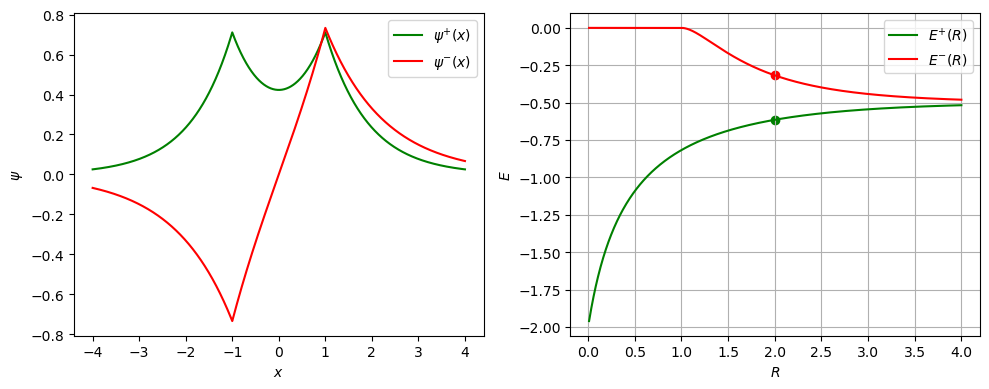

In [8]:
lambdda=1.0 ## See other plots in appendix with this value changed
R=2.0 ##See other plots in appendix with this value changed
new_p=PhysicalParameters(lambdda,R)
x=new_p.grid()
psi_e=psi_even(x,new_p)      
psi_o=psi_odd(x,new_p)      
#curves and points 
R_scan=np.linspace(0.01,4.0,1000)
E_e= -0.5*alpha_main(lambdda,R_scan,1)**2
E_o= -0.5*alpha_main(lambdda,R_scan,-1)**2
E_epoint= -0.5*alpha_main(lambdda,R,1)**2
E_opoint= -0.5*alpha_main(lambdda,R,-1)**2

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
# Wave functions plot
ax1.plot(x,psi_e,color='green',label=r'$\psi^{+}(x)$')
ax1.plot(x,psi_o,color='red',label=r'$\psi^{-}(x)$')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\psi$')
ax1.legend()
# energies plot
ax2.plot(R_scan,E_e,color='green',label=r'$E^{+}(R)$')
ax2.plot(R_scan,E_o,color='red',label=r'$E^{-}(R)$')
ax2.scatter([R],[E_epoint],color='green')
ax2.scatter([R],[E_opoint],color='red')
ax2.set_xlabel(r'$R$')
ax2.set_ylabel(r'$E$')
ax2.legend()

fig.tight_layout()
plt.grid(True)
plt.show()

**In the left figure the green curve is the even-parity (bonding) wave-function $\psi^{+}(x)$, it has no node at the origin and resembles the $1\sigma_{gerade}$ orbital of the hydrogen molecular ion $\mathrm{H}_2^{+}$. The red curve is the odd-parity (anti-bonding) state $\psi^{-}(x)$, which changes sign at $x = 0$ just as the $1\sigma_{ungerade}$ orbital does in three dimensions. Both curves peak at the two delta-wells located at $x = \pm R/2$.**

**The right figure tracks how the corresponding energies vary with internuclear distance. As $R \rightarrow 0$ the two wells merge and the splitting is large, as $R \rightarrow \infty$ the wells decouple and both energies approach the single-well value $E = -\tfrac12\lambda^{2}$. The green and red dots mark the analytic energies at the chosen $R = 2$ namely $E_{+}\approx{-0.61}$ and $E_{-}\approx{-0.31}$. These are identical to numerical precision solution and to the two most negative eigenvalues extracted from the finite-difference Hamiltonian we did before in a previous section so the markers serve as a visual confirmation that the analytic and numeric treatments are in complete agreement. The vertical separation between the two curves at any $R$ is the tunnelling induced splitting that stabilises the bonding state exactly mirroring the physical picture of electron sharing in the real $\mathrm{H}_2^{+}$ molecule.**

**We can check in the appendix, plots for different values of lambdda and R**

Next we do a Grid-convergence test to check for normalisation error

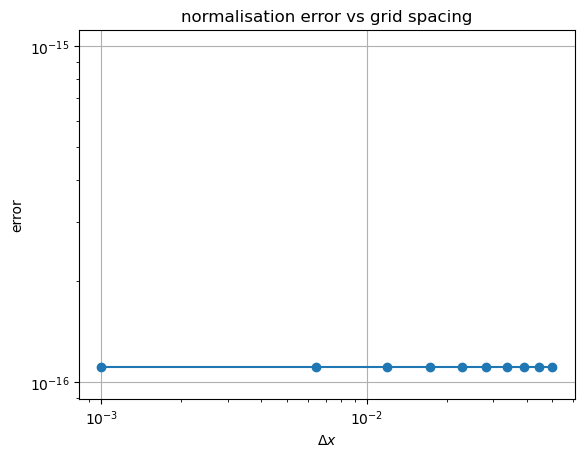

In [9]:
lambdda=1.0 # Change this 
R=0.5 # Change this
dx_list=np.linspace(0.001,0.05,10)
errors=[]
for dx in dx_list:
    nx=int((8.0)/dx)+1           
    new_p2=PhysicalParameters(lambdda,R)
    x=new_p2.grid()
    norm=np.trapz(psi_even(x,new_p2)**2,x) #checking for only one alpha
    errors.append(abs(1.0-norm))

fig,ax=plt.subplots()
ax.loglog(dx_list,errors,'o-')
ax.set_xlabel(r'$\Delta x$')
ax.set_ylabel(r'error')
ax.set_title('normalisation error vs grid spacing')
plt.grid(True)
plt.show()

The decay constant $\alpha_{+}$ makes the wave-function almost flat throughout the interval. The error curve looks to sits on a horizontal line at the $10^{-15}or10^{-16}$ level. So any further grid refinement would only waste CPU time without improving accuracy.

Next, we scan the parameter space to understand energy splitting. We first build two axes for the well strength (vertical axis) and separation (horizontal axis), then create a full rectangular grid of every $(\lambda,R)$ pair. Using the analytic formula $\alpha_{\pm}(\lambda,R)$ evaluats $E^{+}(R,\lambda)$ and $E^{-}(R,\lambda)$ at each
node and store the splitting

$$
\Delta E(R,\lambda)=E^{-}-E^{+}=\frac12\bigl(\alpha_{+}^{2}-\alpha_{-}^{2}\bigr)
\tag{9}
$$  

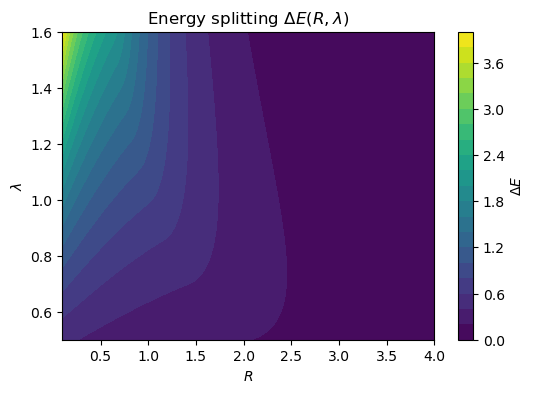

In [10]:
lambddaa=np.linspace(0.5,1.6,80)   # y–axis # Stretch it if you want
Rr=np.linspace(0.1,4.0,120)  # x–axis # Stretch it if you want
y,RR=np.meshgrid(lambddaa,Rr,indexing='ij') #rect grid
alpha_plus=alpha_main(y,RR,1)
alpha_minus=alpha_main(y,RR,-1)
DeltaE = 0.5*(alpha_plus**2 - alpha_minus**2) #splitting  

fig,ax=plt.subplots(figsize=(6,4))
cs=ax.contourf(RR,y,DeltaE,levels=20)
fig.colorbar(cs,ax=ax,label=r'$\Delta E$')
ax.set_xlabel(r'$R$')
ax.set_ylabel(r'$\lambda$')
ax.set_title(r'Energy splitting $\Delta E(R,\lambda)$')
plt.show()

**The resulting plot tells us how large the bonding–antibonding gap is for any combination of well depth and distance. Bright yellow in the upper-left corner corresponds to large splitting as small separations and strong wells let the exponential tails from the two delta centres overlap strongly, exactly the situation of the tightly bound $\mathrm{H}_2^{+}$ molecule at short internuclear distance. Moving rightward (increasing $R$) or downward (weakening $\lambda$) darkens the plot as the two wells decouple, tunnelling vanishes and $\Delta E\to 0$. Physically this is the dissociation limit where the bonding and anti-bonding states become degenerate 1s orbitals on two independent protons.**

**The curvature of the contour lines also encodes the fact that the splitting falls off exponentially with $R$. Thus the diagram summarises in one picture the entire bonding story of the one-dimensional hydrogen molecular ion: strong, short-range attraction at small $R$ and two isolated atoms beyond a few units of $1/\lambda$.**

Now, an extra step to understand computational effeciency

In [11]:
def compef(lambdda,R,n_iter=50):
    t0=time.perf_counter()
    for i in range(n_iter):
        i = alpha_main(lambdda,R,1)
    t1 = time.perf_counter()

    for j in range(n_iter):
        j = alpha_evennum(PhysicalParameters(lambdda,R))
    t2 = time.perf_counter()

    print(f"analytic: {(t1-t0)/n_iter:.2e} s per call")
    print(f"numeric: {(t2-t1)/n_iter:.2e} s per call")
    
compef(1.0, 2.0)

analytic: 1.13e-05 s per call
numeric: 4.17e-05 s per call


It was known that analytic way will be faster but interesting to know by how much. Resorting to Newton method (or any other iterative root-finder) only becomes worthwhile in future studies if we lack a closed-form expression or wish to validate that the analytic formula grabs the correct root.

## Conclusion

**We used a pair of transcendental equations for the decay constants $\alpha_{\pm}$ and solved them in closed form with the Lambert-$W$ function, yielding the energies $E_{\pm}= -\alpha_{\pm}^{2}/2$ and the normalised bonding/anti-bonding wave functions. Newton method gave an independent numerical solution while a finite difference Hamiltonian confirmed that the analytic energies really are the two lowest eigenvalues of the discrete Schrodinger operator. Then we visually explored the real-space shapes of $\psi^{\pm}(x)$ to their energy curves $E^{\pm}(R)$, and a contour map $\Delta E(R,\lambda)$ revealed how tunnelling splitting depends on well strength and separation, mirroring the bonding physics of $\mathrm{H}_2^{+}$. It was also verified that the determinant condition vanishes, demonstrated normalisation error even on coarse grids, and timing tests showed the Lambert-$W$ route is faster than an iterative Newton search.**

### List of references

[1] S. Blinder, "Analytic Solutions for Double Deltafunction Potential," 2021. [Online]. Available: https://demonstrations.wolfram.com/AnalyticSolutionsForDoubleDeltafunctionPotential/. [Accessed April 2025].

[2] Wikipedia, "Delta potential," [Online]. Available: https://en.wikipedia.org/wiki/Delta_potential#Double_delta_potential. [Accessed April 2025].

[3] P. S. Exchange, "Bound States in a Double Delta Function Potential," [Online]. Available: https://physics.stackexchange.com/questions/43510/bound-states-in-a-double-delta-function-potential. [Accessed April 2025].

[4] M. S. V. S. Sachin Kumar, "Revisiting double Dirac delta potential," arXiv, vol. 1603, no. 07726v4, 2016. 

[5] Griﬃth D J 2011 Introduction to Quantum Mechanics (Pearson) 2nd ed. pp. 83-85, 89.


### Appendix

This is the same code for wave function and energies but with changed values

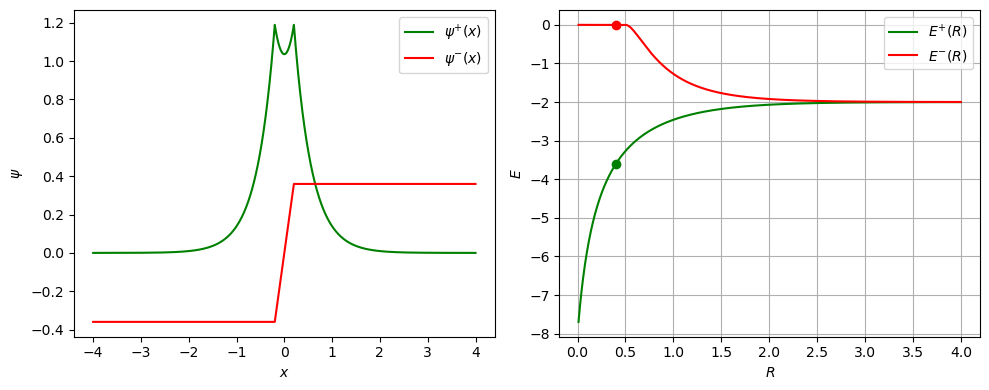

In [12]:
lambdda=2.0 ## value changed
R=0.4 ##value changed
new_p=PhysicalParameters(lambdda,R)
x=new_p.grid()
psi_e=psi_even(x,new_p)      
psi_o=psi_odd(x,new_p)      

R_scan=np.linspace(0.01,4.0,1000)
E_e= -0.5*alpha_main(lambdda,R_scan,1)**2
E_o= -0.5*alpha_main(lambdda,R_scan,-1)**2
E_epoint= -0.5*alpha_main(lambdda,R,1)**2
E_opoint= -0.5*alpha_main(lambdda,R,-1)**2

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))

ax1.plot(x,psi_e,color='green',label=r'$\psi^{+}(x)$')
ax1.plot(x,psi_o,color='red',label=r'$\psi^{-}(x)$')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\psi$')
ax1.legend()

ax2.plot(R_scan,E_e,color='green',label=r'$E^{+}(R)$')
ax2.plot(R_scan,E_o,color='red',label=r'$E^{-}(R)$')
ax2.scatter([R],[E_epoint],color='green')
ax2.scatter([R],[E_opoint],color='red')
ax2.set_xlabel(r'$R$')
ax2.set_ylabel(r'$E$')
ax2.legend()

fig.tight_layout()
plt.grid(True)
plt.show()

This is known as the tight binding limit: Strong intereference, wide gap in eigenenergies. Some times even the bound state (odd wave function) may dissapear

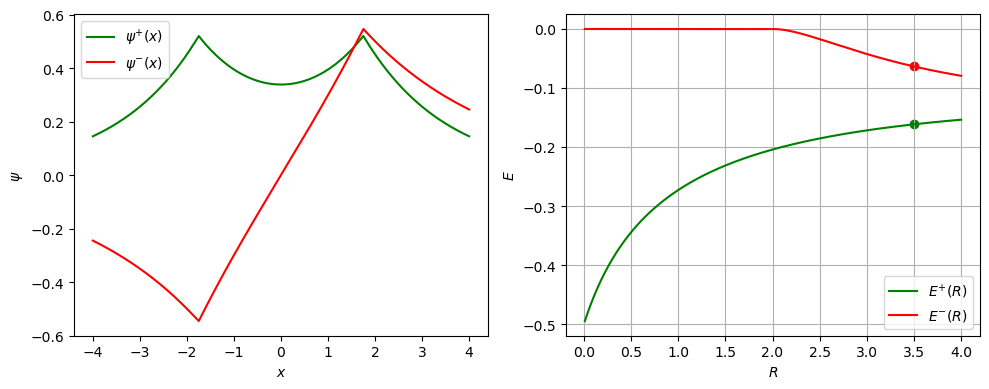

In [13]:
lambdda=0.5 ## See other plots in appendix with this value changed
R=3.5 ##See other plots in appendix with this value changed
new_p=PhysicalParameters(lambdda,R)
x=new_p.grid()
psi_e=psi_even(x,new_p)      
psi_o=psi_odd(x,new_p)      

R_scan=np.linspace(0.01,4.0,1000)
E_e= -0.5*alpha_main(lambdda,R_scan,1)**2
E_o= -0.5*alpha_main(lambdda,R_scan,-1)**2
E_epoint= -0.5*alpha_main(lambdda,R,1)**2
E_opoint= -0.5*alpha_main(lambdda,R,-1)**2

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))

ax1.plot(x,psi_e,color='green',label=r'$\psi^{+}(x)$')
ax1.plot(x,psi_o,color='red',label=r'$\psi^{-}(x)$')
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$\psi$')
ax1.legend()

ax2.plot(R_scan,E_e,color='green',label=r'$E^{+}(R)$')
ax2.plot(R_scan,E_o,color='red',label=r'$E^{-}(R)$')
ax2.scatter([R],[E_epoint],color='green')
ax2.scatter([R],[E_opoint],color='red')
ax2.set_xlabel(r'$R$')
ax2.set_ylabel(r'$E$')
ax2.legend()

fig.tight_layout()
plt.grid(True)
plt.show()

Dissociation limit: localised electron